### Importing standard libraries

In [1]:
import sys
import random
import numpy as np
import pandas as pd
import torch

from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler

### Installing pytorch-geometric

In [2]:
if torch.cuda.is_available():
    !pip install --no-index --no-deps -q /kaggle/input/torch-geometric-gpu/wheelhouse/*.whl;
else:
    !pip install --no-index --no-deps -q /kaggle/input/torch-geometric-cpu/wheelhouse/*.whl;

In [3]:
!rm  -r software
!scp -r /kaggle/input/graphnet-and-dependencies/software .

rm: cannot remove 'software': No such file or directory


In [4]:
!cd software/graphnet;pip install --no-index -q --find-links="/kaggle/working/software/dependencies" -e .[torch];

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.6.2 requires tqdm<4.65,>=4.48.2, but you have tqdm 4.65.0 which is incompatible.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [5]:
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn.pool import knn_graph

### Importing EdgeModel

In [6]:
sys.path.append('/kaggle/input/icecube-model')
from EdgeModel import EdgeModel

### Setting seed = 0 for reproducibility and constants

In [7]:
INPUT_PATH = "/kaggle/input/icecube-neutrinos-in-deep-ice"
TRANSPARENCY_PATH = "/kaggle/input/icecubetransparency/ice_transparency.txt"
MODEL_PATH = "/kaggle/input/gnn-ready-model/EdgeConvV10.pth"
MODE = 'train'
TRAIN_BATCHES = 3

_dtype = {
    "batch_id": "int16",
    "event_id": "int64",
}

In [8]:
def seed_settings(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_settings(seed=0)

## Dataset

### Making features using ice transparency data

In [9]:
# Ice Data Taken from Measurement of South Pole ice transparency with the IceCube
# LED calibration system https://arxiv.org/pdf/1301.5361.pdf
!cat /kaggle/input/icecubetransparency/ice_transparency.txt

depth scattering_len absorption_len
1398.4 13.2 45.1
1408.4 14.0 48.6
1418.4 14.7 53.2
1428.4 17.0 57.6
1438.4 16.0 57.6
1448.4 14.4 52.2
1458.4 16.0 60.1
1468.4 20.8 74.6
1478.4 26.7 96.6
1488.4 34.7 110.5
1498.4 39.7 135.6
1508.5 38.7 134.7
1518.6 27.8 98.2
1528.7 16.6 64.7
1538.8 13.7 48.5
1548.7 13.5 44.3
1558.7 15.7 54.4
1568.5 15.7 56.7
1578.5 14.7 52.1
1588.5 17.6 60.7
1598.5 21.6 72.7
1608.5 24.0 78.9
1618.5 20.0 68.7
1628.5 17.8 66.6
1638.5 28.9 100.0
1648.4 36.9 128.6
1658.4 42.1 148.2
1668.4 46.5 165.7
1678.5 45.4 156.0
1688.5 39.1 138.5
1698.5 30.6 113.9
1708.5 26.5 90.2
1718.5 19.3 73.5
1728.5 20.8 75.9
1738.5 20.1 67.8
1748.5 20.3 68.6
1758.5 24.5 83.8
1768.5 33.5 119.5
1778.5 36.2 121.6
1788.5 35.4 108.3
1798.5 32.3 113.4
1808.5 40.2 139.1
1818.4 44.7 148.1
1828.4 34.5 122.8
1838.4 30.6 113.8
1848.4 27.5 89.9
1858.4 19.7 71.7
1868.5 21.4 70.6
1878.5 28.8 95.9
1888.5 38.3 116.5
1898.5 38.4 143.6
1908.5 44.2 169.4
1918.5 50.5 178.0
1928.5 46.6 156.5
1938.5 36.8 135.3
1948.

In [10]:
def ice_transparency(data_path, center_depth=1950):
    """
    Calculates normalized ice scattering and absorption for all depths,
    using data from Measurement of South Pole ice transparency with the IceCube
    LED calibration system

    Center_depth is center of IceCube underground array
    """
    sensor_amount = 500

    df = pd.read_csv(data_path, delim_whitespace=True)
    df["z_score"] = (df["depth"] - center_depth) / sensor_amount
    df[["scattering_len_norm", "absorption_len_norm"]] = RobustScaler().fit_transform(
        df[["scattering_len", "absorption_len"]]
    )

    # These are both roughly equivalent after scaling
    # TODO: Make new feature (1-(sc+ab)/2)?
    f_scattering = interp1d(df["z_score"], df["scattering_len_norm"])
    f_absorption = interp1d(df["z_score"], df["absorption_len_norm"])
    return f_scattering, f_absorption

### Making Dataset class

In [11]:
class IceCubeDataset(Dataset):
    """
    Used to transfer data from table format to graph format, with each event
    represented by singular graph
    """
    def __init__(
        self,
        batch_id,
        event_ids,
        sensor_df,
        mode="test",
        y=None,
        pulse_limit=220,  # >95% events have 220 pulses or less
    ):
        super().__init__()
        self.y = y
        self.event_ids = event_ids
        self.batch_df = pd.read_parquet(f"{INPUT_PATH}/{mode}/batch_{batch_id}.parquet")
        self.sensor_df = sensor_df
        self.pulse_limit = pulse_limit
        self.f_scattering, self.f_absorption = ice_transparency(TRANSPARENCY_PATH)
        # Rescaling parameters
        self.batch_df["time"] = (self.batch_df["time"] - 1.0e04) / 3.0e4
        self.batch_df["charge"] = np.log10(self.batch_df["charge"]) / 3.0
        self.batch_df["auxiliary"] = self.batch_df["auxiliary"].astype(int) - 0.5

    def len(self):
        return len(self.event_ids)

    def get(self, idx):
        """
        Returns data for given event index
        """
        event_id = self.event_ids[idx]
        event = self.batch_df.loc[event_id]

        # represent each event by a single graph
        event = pd.merge(event, self.sensor_df, on="sensor_id")
        col = ["x", "y", "z", "time", "charge", "auxiliary"]

        x = event[col].values.astype(float)
        x = torch.tensor(x, dtype=torch.float32)
        # A data object describing a homogeneous graph
        data = Data(x=x, n_pulses=torch.tensor(x.shape[0], dtype=torch.int32))

        # Downsample the large events
        if data.n_pulses > self.pulse_limit:
            data.x = data.x[np.random.choice(data.n_pulses, self.pulse_limit)]
            data.n_pulses = torch.tensor(self.pulse_limit, dtype=torch.int32)

        # Builds graph from the k-nearest neighbours.
        data.edge_index = knn_graph(
            data.x,  # x, y, z
            k=8,
            cosine=False,
            loop=False
        )

        if self.y is not None:
            y = self.y.loc[idx, :].values
            y = torch.tensor(y, dtype=torch.float32)
            data.y = y

        return data

### Preparing sensors data

In [12]:
def prepare_sensors():
    """
    Preparing sensors position and quantum efficiency to be used
    as input to model
    """
    sensors = pd.read_csv(f"{INPUT_PATH}/sensor_geometry.csv").astype(
        {
            "sensor_id": np.int16,
            "x": np.float32,
            "y": np.float32,
            "z": np.float32,
        }
    )
    sensors["string"] = 0
    sensors["qe"] = 1

    # 60 DOMs per string
    for i in range(len(sensors) // 60):
        start, end = i * 60, (i * 60) + 60
        sensors.loc[start:end, "string"] = i

        # High Quantum Efficiency in the lower 50 DOMs
        # https://arxiv.org/pdf/2209.03042.pdf (Figure 1)
        # DeepCore located on 8 strings
        if i in range(78, 86):
            start_veto, end_veto = i * 60, (i * 60) + 10
            start_core, end_core = end_veto + 1, (i * 60) + 60
            # The DOMs deployed in DeepCore have an efficiency that is roughly
            # a factor of 1.35 times the QE of standard DOMs
            sensors.loc[start_core:end_core, "qe"] = 1.35

    # https://github.com/graphnet-team/graphnet/blob/b2bad25528652587ab0cdb7cf2335ee254cfa2db/src/graphnet/models/detector/icecube.py#L33-L41
    # Assume that "rde" (relative dom efficiency) is equivalent to QE
    sensors["x"] /= 500
    sensors["y"] /= 500
    sensors["z"] /= 500
    sensors["qe"] -= 1.25
    sensors["qe"] /= 0.25

    return sensors

In [13]:
print(f"{INPUT_PATH}/train_meta.parquet")

/kaggle/input/icecube-neutrinos-in-deep-ice/train_meta.parquet


In [14]:
sensors = prepare_sensors()
sensors

,sensor_id,x,y,z,string,qe
0,0,-0.51228,-1.04216,0.99206,0,-1.0
1,1,-0.51228,-1.04216,0.95802,0,-1.0
2,2,-0.51228,-1.04216,0.92398,0,-1.0
3,3,-0.51228,-1.04216,0.88994,0,-1.0
4,4,-0.51228,-1.04216,0.85590,0,-1.0
...,...,...,...,...,...,...
5155,5155,-0.02194,0.01344,-0.94478,85,0.4
5156,5156,-0.02194,0.01344,-0.95878,85,0.4
5157,5157,-0.02194,0.01344,-0.97280,85,0.4
5158,5158,-0.02194,0.01344,-0.98682,85,0.4


In [15]:
meta = pd.read_parquet(
   f"{INPUT_PATH}/train_meta.parquet", columns=["batch_id", "event_id", "azimuth", "zenith"]
).astype(_dtype)
meta

,batch_id,event_id,azimuth,zenith
0,1,24,5.029555,2.087498
1,1,41,0.417742,1.549686
2,1,59,1.160466,2.401942
3,1,67,5.845952,0.759054
4,1,72,0.653719,0.939117
...,...,...,...,...
131953919,660,2147483597,5.895612,0.333071
131953920,660,2147483603,3.273695,1.503301
131953921,660,2147483617,2.945376,1.723253
131953922,660,2147483626,1.616582,1.937025


In [16]:
batch_ids = meta["batch_id"].unique()

## Graph Summary

In [17]:
batch = 1
event_ids = meta[meta["batch_id"] == batch]["event_id"].tolist()
y = meta[meta["batch_id"] == batch][['zenith', 'azimuth']].reset_index(drop=True)
train_dataset = IceCubeDataset(batch, event_ids, sensors, mode='train', y=y)

In [18]:
print()
print(f'Dataset: {train_dataset}:')
print('====================')
print(f'Number of graphs: {len(train_dataset)}')
print(f'Number of features: {train_dataset.num_features}')

train_data = train_dataset[30]  # Get the first graph object.

print()
print(train_data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {train_data.num_nodes}')
print(f'Number of edges: {train_data.num_edges}')
print(f'Average node degree: {train_data.num_edges / train_data.num_nodes:.2f}')
print(f'Has isolated nodes: {train_data.has_isolated_nodes()}')
print(f'Has self-loops: {train_data.has_self_loops()}')
print(f'Is undirected: {train_data.is_undirected()}')


Dataset: IceCubeDataset(200000):
Number of graphs: 200000
Number of features: 6

Data(x=[109, 6], n_pulses=109, edge_index=[2, 872], y=[2])
Number of nodes: 109
Number of edges: 872
Average node degree: 8.00
Has isolated nodes: False
Has self-loops: False
Is undirected: False


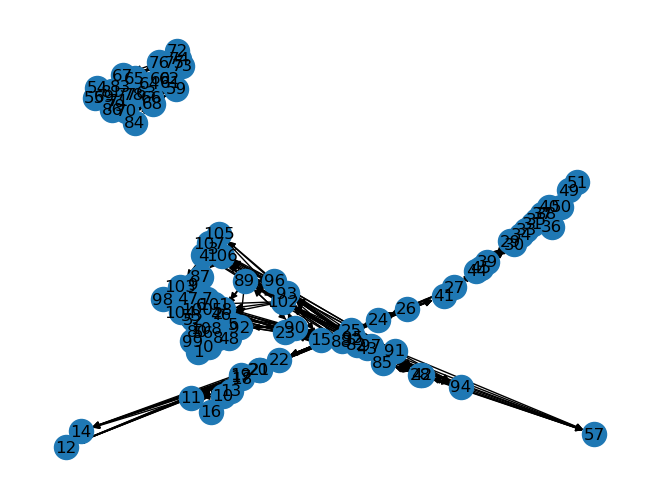

In [19]:
import networkx as nx
from torch_geometric.utils import to_networkx

nxg = to_networkx(train_data)
nx.draw(nxg, with_labels=True)

## Model

In [20]:
model = EdgeModel(train_dataset.num_features)
print(model)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using ', device)
model = model.to(device)

EdgeModel(
  (convolution): ModuleList(
    (0): DynEdgeConv(nn=Sequential(
      (0): Linear(in_features=12, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=128, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    ))
    (1): DynEdgeConv(nn=Sequential(
      (0): Linear(in_features=512, out_features=336, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=336, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    ))
    (2): DynEdgeConv(nn=Sequential(
      (0): Linear(in_features=512, out_features=336, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=336, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    ))
  )
  (post_process): Sequential(
    (0): Linear(in_features=774, out_features=336, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=336, out_features=256, bias=True

## Training

In [21]:
if MODE == 'train':
    for batch in random.sample(range(1, 600), TRAIN_BATCHES):
        i = 1
        path = '/kaggle/working/EdgeConvV3_batch_' + str(i) + '.pth'
        print(f'Batch: {batch:03d}')
        print('====================')
        event_ids = meta[meta["batch_id"] == batch]["event_id"].tolist()
        y = meta[meta["batch_id"] == batch][['azimuth', 'zenith']].reset_index(drop=True)

        train_dataset = IceCubeDataset(batch, event_ids, sensors, mode='train', y=y)
        loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
        print(device)
        model.fit(loader, device=device)
        torch.save(model, path)
elif MODE == 'resume':
    model = torch.load(MODEL_PATH)
    for batch in random.sample(range(1, 600), TRAIN_BATCHES):
        i = 1
        path = '/kaggle/working/EdgeConvV3_batch_' + str(i) + '.pth'
        print(f'Batch: {batch:03d}')
        print('====================')
        event_ids = meta[meta["batch_id"] == batch]["event_id"].tolist()
        y = meta[meta["batch_id"] == batch][['azimuth', 'zenith']].reset_index(drop=True)

        train_dataset = IceCubeDataset(batch, event_ids, sensors, mode='train', y=y)
        loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
        print(device)
        model.fit(loader, device=device)
        torch.save(model, path)
else:
    model = torch.load(MODEL_PATH)

Batch: 395
cuda
Epoch: 0, Loss: 1.5354
Epoch: 1, Loss: 1.5339
Epoch: 2, Loss: 1.5332
Epoch: 3, Loss: 1.5324
Epoch: 4, Loss: 1.5223
Epoch: 5, Loss: 1.4950
Batch: 431
cuda
Epoch: 0, Loss: 1.4749
Epoch: 1, Loss: 1.4607
Epoch: 2, Loss: 1.4442
Epoch: 3, Loss: 1.4259
Epoch: 4, Loss: 1.4120
Epoch: 5, Loss: 1.4005
Batch: 042
cuda
Epoch: 0, Loss: 1.3977
Epoch: 1, Loss: 1.3884
Epoch: 2, Loss: 1.3844
Epoch: 3, Loss: 1.3786
Epoch: 4, Loss: 1.3762
Epoch: 5, Loss: 1.3725


In [22]:
torch.save(model, '/kaggle/working/EdgeConvV6.pth')

## Validation

## TODO
validate using competition metric

In [23]:
batch = random.randint(601, 660)
print(batch)

event_ids = meta[meta["batch_id"] == batch]["event_id"].tolist()
y = meta[meta["batch_id"] == batch][['azimuth', 'zenith']].reset_index(drop=True)

val_dataset = IceCubeDataset(batch, event_ids, sensors, mode='train', y=y)
loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
output = model.validate(loader, device=device)

617
Loss: 1.3990
